# Object Detection with YOLOv8 (+ how to convert our own dataset to yolo format) (estimated time 20-30 mins)
<br>Last updated on 30/08/2025</br>
    <br>We aim to detect objects consisting of 20 classes: person, bird, cat, dog, horse, sheep, aeroplane, bicycle, boat, bicycle, boat, bus, car, motorbike, train, bottle, chair, dining table, potted plant, sofa, and TV monitor. **Pascal VOC Detection Dataset** (http://host.robots.ox.ac.uk/pascal/VOC/) and **YOLOv8** (https://docs.ultralytics.com/datasets/detect/voc/) are employed for the trial. The code is modified form https://colab.research.google.com/github/ultralytics/ultralytics/blob/main/examples/tutorial.ipynb. <br>

     from previous notebook we using their dataset that been set up for yolo. now, we will learn about custom our own dataset.


In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.0/235.7 GB disk)


In [ ]:
# Import necessary libraries
import os
import requests
import tarfile
from tqdm import tqdm

## Download Pascal-VOC 2007 dataset
- From Kaggle.

- This dataset is a mirror of the original PASCAL VOC 2007, provided for research and non-commercial use only.

### How to download with the Kaggle API
- Get your Kaggle API token (kaggle.json)

`Go to Kaggle → Profile photo → Account → Create New Token.`

- you got kaggle.json (contains your username + API key). [how to create api](https://www.kaggle.com/docs/api#authentication)

In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/zaraks/pascal-voc-2007
License(s): other







User cancelled operation
unzip:  cannot find or open /content/voc2007/pascal-voc-2007.zip, /content/voc2007/pascal-voc-2007.zip.zip or /content/voc2007/pascal-voc-2007.zip.ZIP.


In [ ]:
!kaggle datasets download -d zaraks/pascal-voc-2007 -p /content/voc2007
#Type 'For research / non-commercial use only'
!unzip -q /content/voc2007/pascal-voc-2007.zip -d /content/voc2007

Dataset URL: https://www.kaggle.com/datasets/zaraks/pascal-voc-2007
License(s): other
For Education / non-commercial use only
pascal-voc-2007.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/voc2007/PASCAL_VOC/PASCAL_VOC/pascal_test2007.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/voc2007/PASCAL_VOC/PASCAL_VOC/pascal_train2007.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/voc2007/PASCAL_VOC/PASCAL_VOC/pascal_train2012.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/voc2007/PASCAL_VOC/PASCAL_VOC/pascal_val2007.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


## Convert VOC format (.xml) to Yolo format (.yaml)

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
from glob import glob
from sklearn.model_selection import train_test_split
import shutil

**To train yolo on custom dataset** we need to setup dataset to  thier structure <br>
( that can see in /content/yolo_annotations) <br>

---

**Yolo .yaml file** need dataset folder that contains <br>
1. train folder <br>
2. val folder <br>

>**Yolo directory** <br>
dataset/<br>
├── images/ <br>
│  &emsp; ├── train/ <br>
│  &emsp;  &emsp; &emsp; ├── 000001.jpg (original image)<br>
│  &emsp; └── val/ <br>
└── labels/ <br>
 &ensp;  &emsp; ├── train/ <br>
 &ensp;  &emsp; └── val/ <br>
 &ensp; &emsp;  &emsp; &emsp; ├── 000001.txt (annotation)<br>


each line of text file is a object that contain: <br>
 **{class x_center y_center width height}** <br>

The example of 000001.txt: <br>
5 0.34419263456090654 0.611 0.4164305949008499 0.262 <br>
0 0.509915014164306 0.51 0.9745042492917847 0.972


In [ ]:
# Define your class names (must match your dataset)
class_names = ["person", "car", "bus", "train", "cat", "dog", "horse", "cow", "sheep", "aeroplane", "motorbike", "sofa", "tvmonitor", "bottle", "chair", "table", "pottedplant"]

voc_annot_folder = '/content/voc2007/voctrainval_06-nov-2007/VOCdevkit/VOC2007/Annotations'
image_folder = '/content/voc2007/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages'
yolo_annot_folder = '/content/yolo_annotations'

In [ ]:
os.makedirs(yolo_annot_folder,exist_ok=True)
os.makedirs(os.path.join(yolo_annot_folder,"images"),exist_ok=True)
os.makedirs(os.path.join(yolo_annot_folder,"labels"),exist_ok=True)
# Create lists for images
image_paths = glob(os.path.join(image_folder, "*.jpg"))
image_filenames = [os.path.basename(path) for path in image_paths]

# Process training and validation annotations
train_annot_folder = os.path.join(yolo_annot_folder, "labels", 'train')
val_annot_folder = os.path.join(yolo_annot_folder, "labels" ,'val')

os.makedirs(train_annot_folder,exist_ok=True)
os.makedirs(val_annot_folder,exist_ok=True)

In [ ]:
# Helper function to process annotations
def process_annotations(file_list, annot_folder):
    for image_filename in file_list:
        xml_file = os.path.join(voc_annot_folder, os.path.splitext(image_filename)[0] + '.xml')
        if not os.path.isfile(xml_file):
            continue

        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Get image size
        image_path = os.path.join(image_folder, image_filename)
        image = cv2.imread(image_path)
        h, w, _ = image.shape

        yolo_annot_file = os.path.join(annot_folder, os.path.splitext(image_filename)[0] + '.txt')
        with open(yolo_annot_file, 'w') as f:
            for obj in root.findall('object'):
                cls = obj.find('name').text
                if cls not in class_names:
                    continue
                cls_id = class_names.index(cls)

                xml_box = obj.find('bndbox')
                b = [int(xml_box.find('xmin').text), int(xml_box.find('ymin').text), int(xml_box.find('xmax').text), int(xml_box.find('ymax').text)]

                # Convert to YOLO format
                x_center = (b[0] + b[2]) / 2.0 / w
                y_center = (b[1] + b[3]) / 2.0 / h
                width = (b[2] - b[0]) / w
                height = (b[3] - b[1]) / h

                f.write(f"{cls_id} {x_center} {y_center} {width} {height}\n")


In [ ]:
# Split dataset into training and validation
train_files, val_files = train_test_split(image_filenames, test_size=0.2, random_state=42)

In [ ]:
process_annotations(train_files, train_annot_folder)
process_annotations(val_files, val_annot_folder)

In [ ]:
# Copy images to respective folders
train_img_folder = os.path.join(yolo_annot_folder, "images", 'train')
val_img_folder = os.path.join(yolo_annot_folder, "images" ,'val')

os.makedirs(train_img_folder,exist_ok=True)
os.makedirs(val_img_folder,exist_ok=True)

for f in train_files:
    shutil.copy(os.path.join(image_folder, f), os.path.join(train_img_folder, f))

for f in val_files:
    shutil.copy(os.path.join(image_folder, f), os.path.join(val_img_folder, f))

In [ ]:
# Create data.yaml file
yaml_content = """
train: /content/yolo_annotations/images/train
val: /content/yolo_annotations/images/val

nc: 17  # Number of classes (change this if your class list differs)
names: ['person', 'car', 'bus', 'train', 'cat', 'dog', 'horse', 'cow', 'sheep', 'aeroplane', 'motorbike', 'sofa', 'tvmonitor', 'bottle', 'chair', 'table', 'pottedplant']
"""

with open('/content/data.yaml', 'w') as f:
    f.write(yaml_content)

In [ ]:
from ultralytics import YOLO

# Load a model
# model = YOLO('yolov8n.yaml')  # build a new model from scratch
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
model.to('cuda:0') # set up the model to GPU
# Use the model
results = model.train(data='data.yaml', epochs=3)  # train the model

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=False, save=True, save_conf=

In [ ]:
from PIL import Image

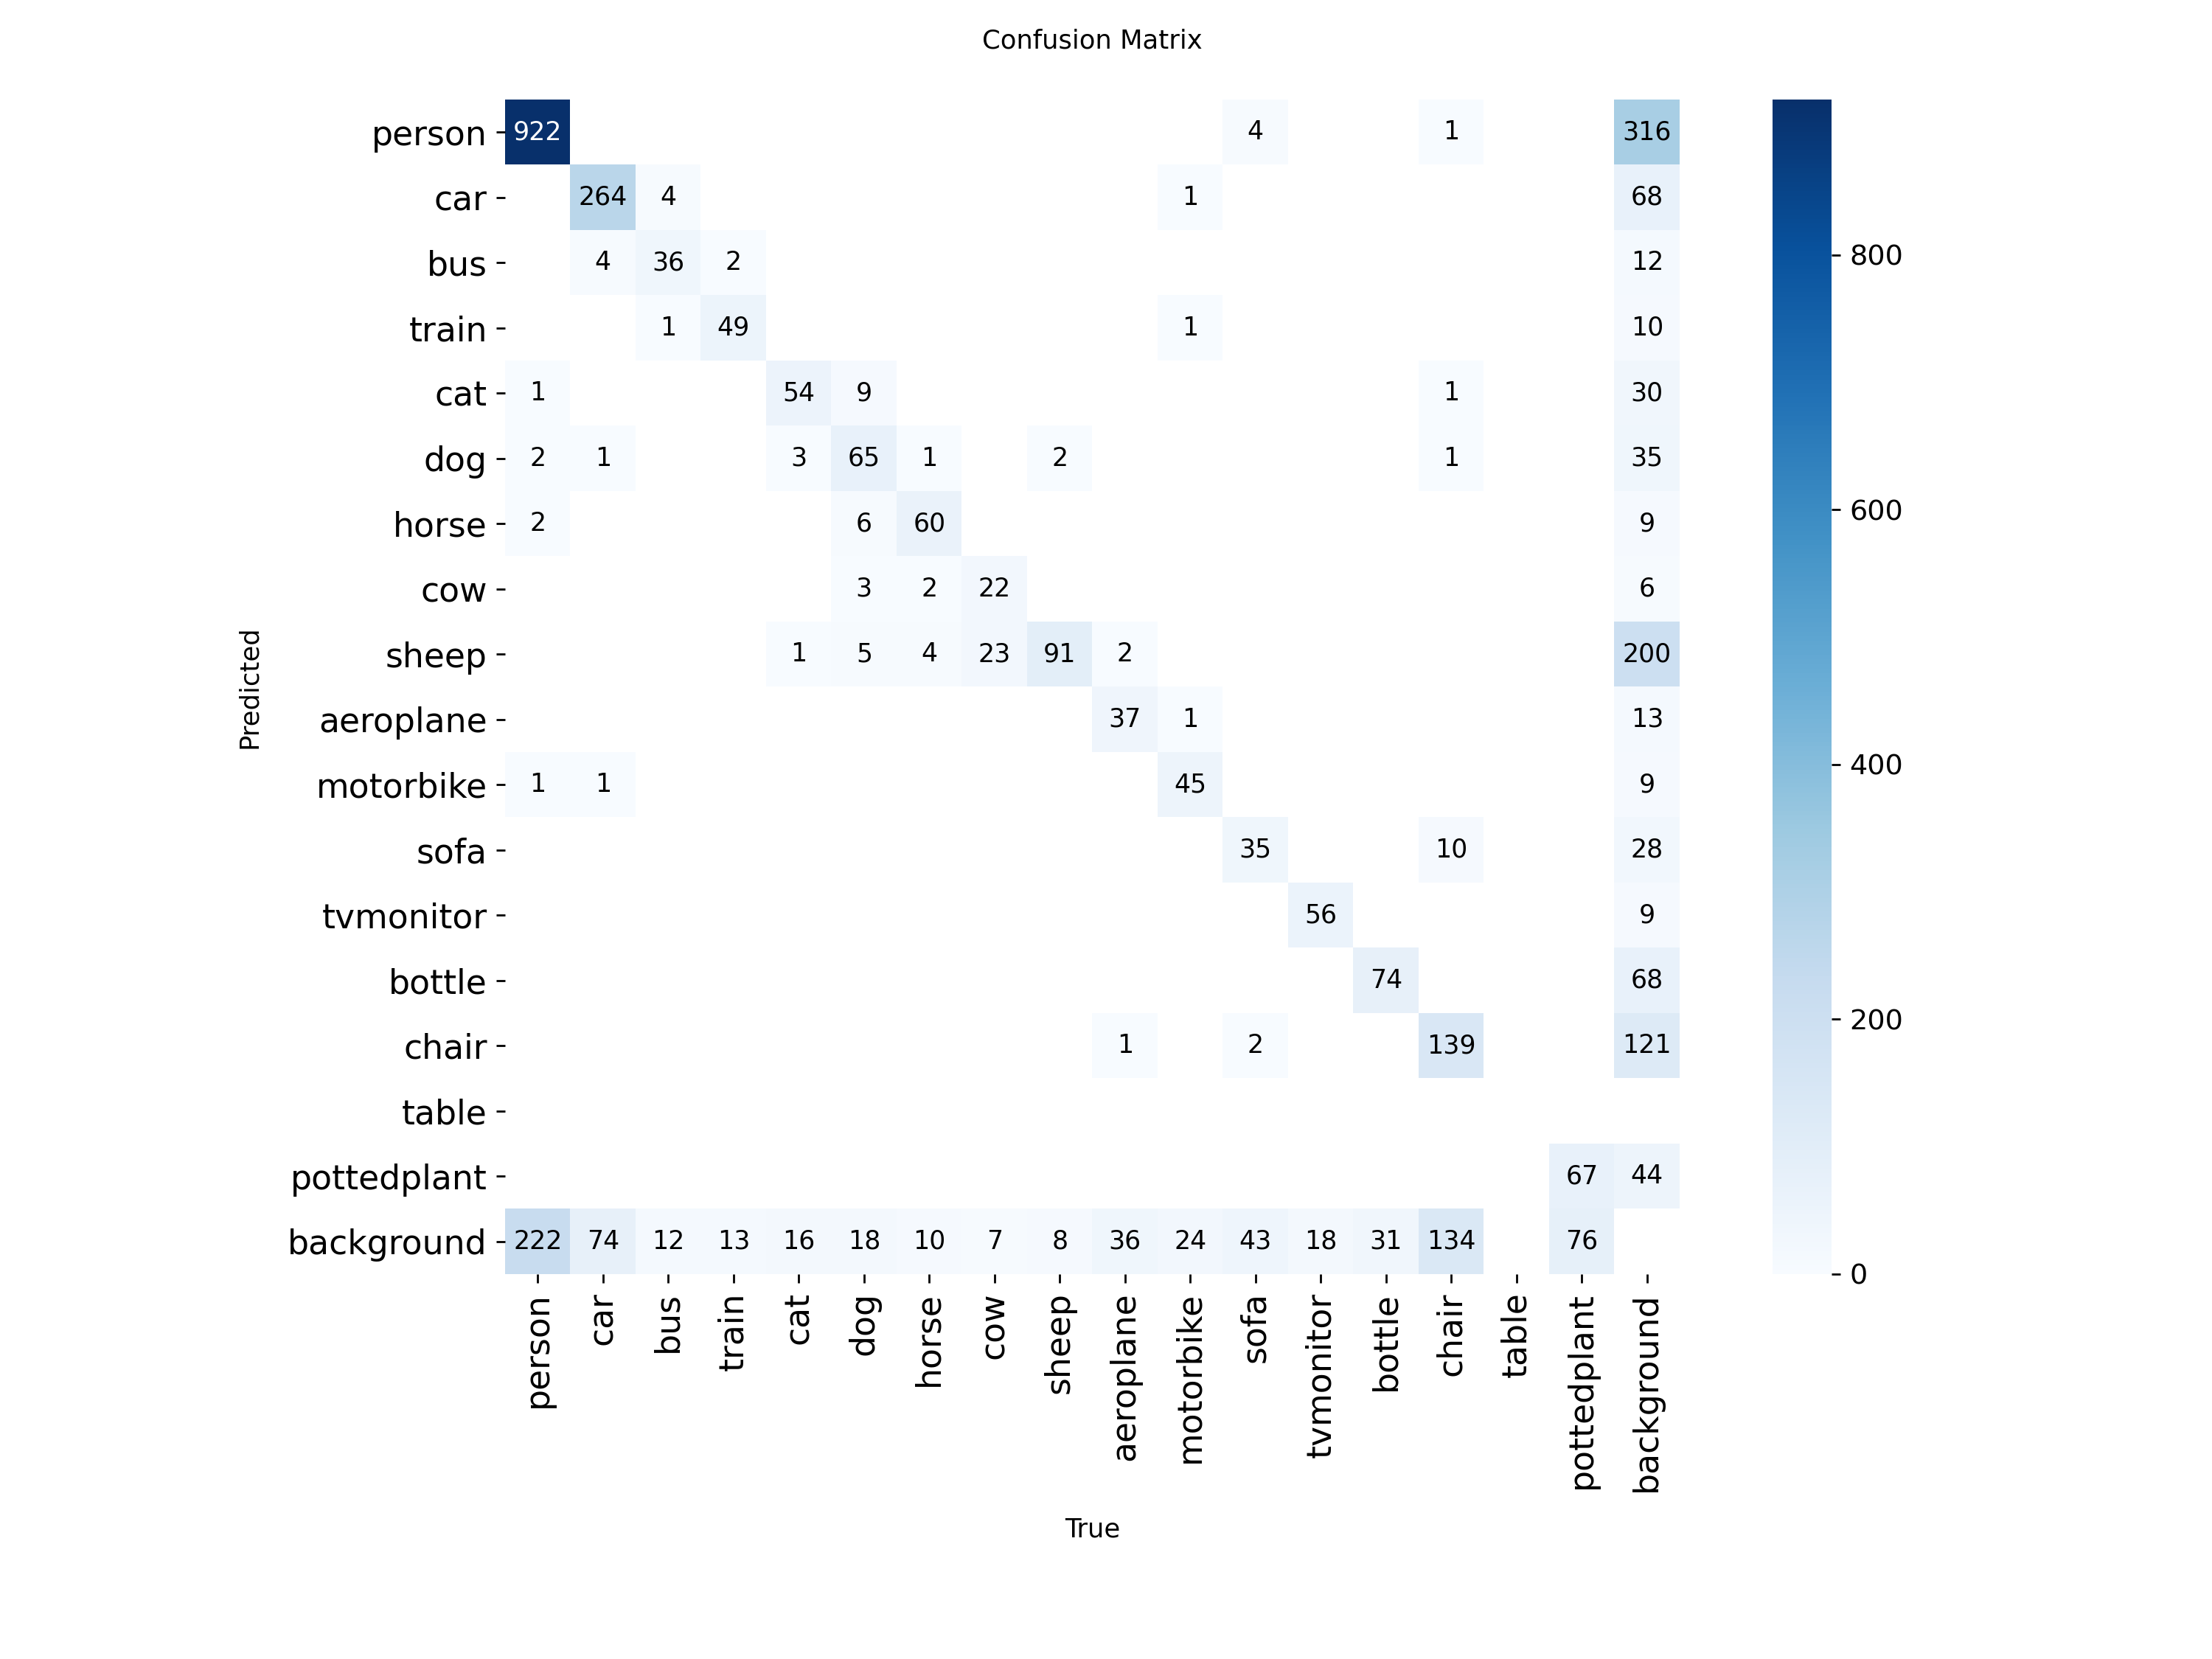

In [ ]:
Image.open("/content/runs/detect/train/confusion_matrix.png")

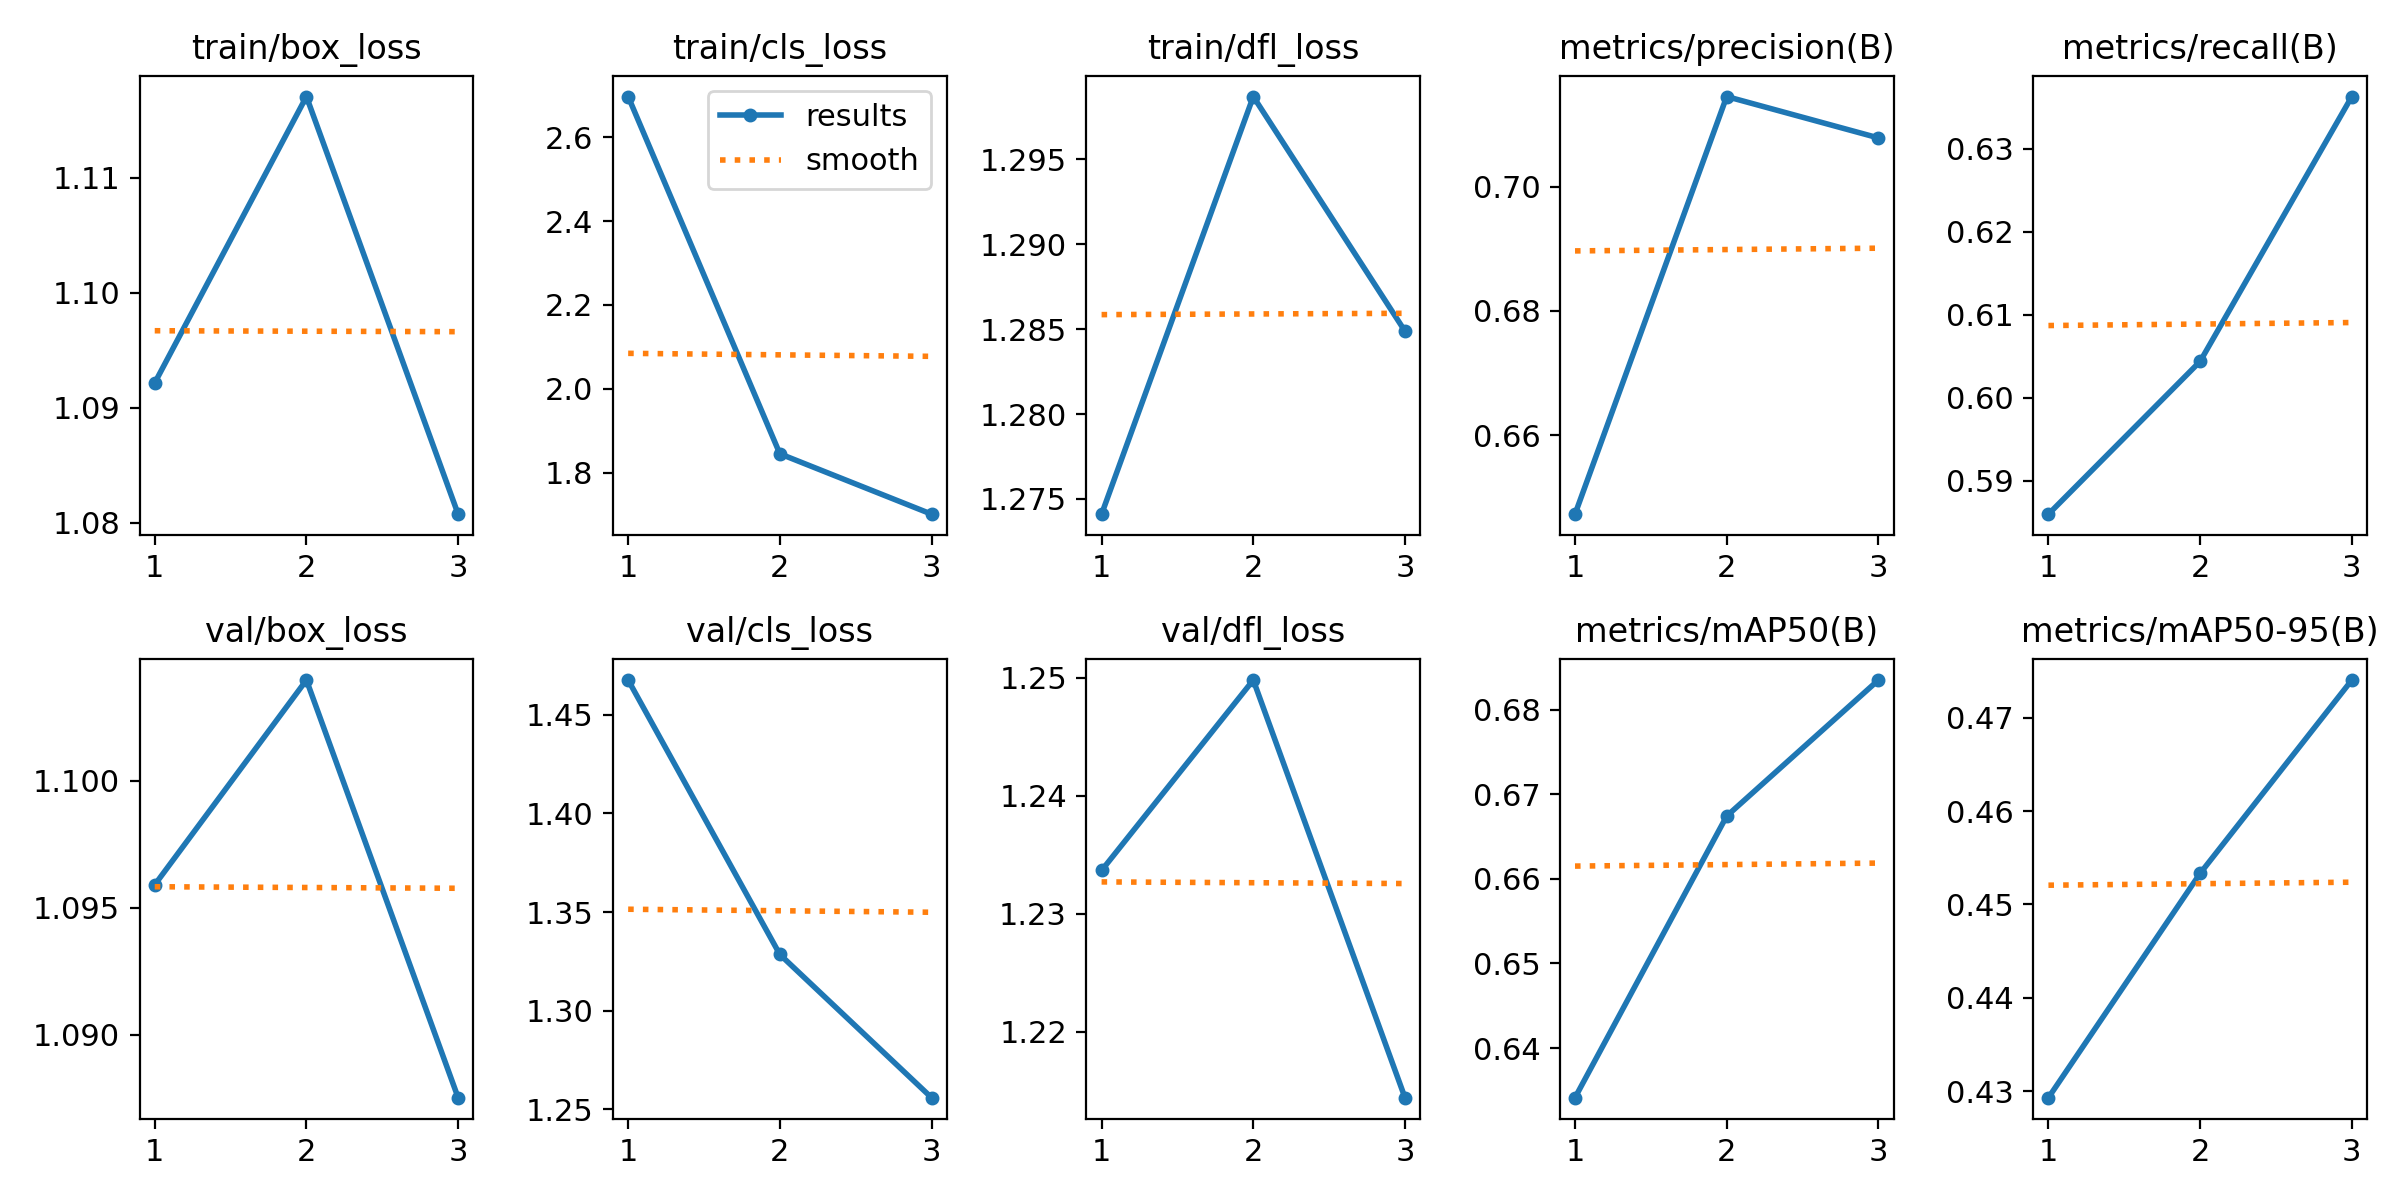

In [ ]:
Image.open("/content/runs/detect/train/results.png")

In [ ]:
Image.open("/content/runs/detect/train/val_batch1_pred.jpg")